<a href="https://colab.research.google.com/github/jkjh23/BusanAIDeveloperCourse_AI/blob/master/3_DeepLearning/11-5_LSTM_%EB%B6%80%EB%8F%99%EC%82%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 불러오기
- 부동산 개별 실거래가는 매달에 맞춰 거래가 일어나지 않는다. 
- 한국감정원에서 배포하는 [전국주택가격지수](http://www.r-one.co.kr/rone/resis/common/sub/sub.do?pageVal=page_2_2) 중에서 강남구 아파트 가격 지수를 이용하여 예측

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
dir = '/content/drive/My Drive/2020_AI_Busan/4_DeepLearning/LSTM_Data/aptsellindex_gangnamgu.csv'
df  = pd.read_csv(dir, parse_dates=['date'], index_col='date', engine='python', encoding='euc-kr', dtype={'trade_price_idx_value' : 'float'})
df

,trade_price_idx_value
date,
2006-01-01,74.2
2006-02-01,75.8
2006-03-01,78.1
2006-04-01,81.4
2006-05-01,83.6
...,...
2018-10-01,109.7
2018-12-01,109.3
2019-01-01,108.3


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 165 entries, 2006-01-01 to 2019-03-01
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   trade_price_idx_value  165 non-null    float64
dtypes: float64(1)
memory usage: 2.6 KB


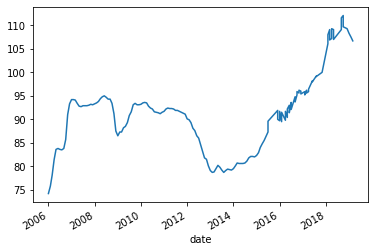

In [ ]:
df['trade_price_idx_value'].plot()

# 데이터 전처리

## 데이터 분할
- 훈련 데이터와 테스트 데이터 분리
  - 2014년 강남구 아파트 매매지수의 저점이 특이점
  - 2017년 1월 1일 이후 데이터를 테스트 데이터로 분리

In [ ]:
split_date = pd.Timestamp('01-01-2017')
train      = df.loc[:split_date, ['trade_price_idx_value']]
test       = df.loc[split_date:, ['trade_price_idx_value']]

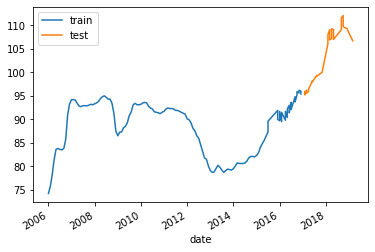

In [ ]:
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])
plt.show()

## 데이터 스케일링


In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc       = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc  = sc.fit_transform(test)

In [ ]:
## 위도우 작업을 위해 판다스 데이터프레임 타입으로 변환
train_sc_df = pd.DataFrame(train_sc, columns=['trade_price_idx_value'], index=train.index)
test_sc_df  = pd.DataFrame(test_sc,  columns=['trade_price_idx_value'], index=test.index)
train_sc_df.shape, test_sc_df.shape

((137, 1), (28, 1))

## Window 구성

In [ ]:
for s in range(1, 13) :
  train_sc_df['shift_{}'.format(s)] = train_sc_df['trade_price_idx_value'].shift(s)
  test_sc_df['shift_{}'.format(s)]  = test_sc_df['trade_price_idx_value'].shift(s)
train_sc_df.head(13)

,trade_price_idx_value,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
date,,,,,,,,,,,,,
2006-01-01,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-02-01,0.072727,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-03-01,0.177273,0.072727,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-04-01,0.327273,0.177273,0.072727,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-05-01,0.427273,0.327273,0.177273,0.072727,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-06-01,0.436364,0.427273,0.327273,0.177273,0.072727,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-07-01,0.427273,0.436364,0.427273,0.327273,0.177273,0.072727,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2006-08-01,0.422727,0.427273,0.436364,0.427273,0.327273,0.177273,0.072727,0.000000,NaN,NaN,NaN,NaN,NaN
2006-09-01,0.436364,0.422727,0.427273,0.436364,0.427273,0.327273,0.177273,0.072727,0.000000,NaN,NaN,NaN,NaN


In [ ]:
X_train = train_sc_df.dropna().drop('trade_price_idx_value', axis=1)
y_train = train_sc_df.dropna()[['trade_price_idx_value']]
print(X_train.head())
print(y_train.head())

             shift_1   shift_2   shift_3  ...  shift_10  shift_11  shift_12
date                                      ...                              
2007-01-01  0.868182  0.763636  0.522727  ...  0.177273  0.072727  0.000000
2007-02-01  0.909091  0.868182  0.763636  ...  0.327273  0.177273  0.072727
2007-03-01  0.909091  0.909091  0.868182  ...  0.427273  0.327273  0.177273
2007-04-01  0.904545  0.909091  0.909091  ...  0.436364  0.427273  0.327273
2007-05-01  0.872727  0.904545  0.909091  ...  0.427273  0.436364  0.427273

[5 rows x 12 columns]
            trade_price_idx_value
date                             
2007-01-01               0.909091
2007-02-01               0.909091
2007-03-01               0.904545
2007-04-01               0.872727
2007-05-01               0.845455


In [ ]:
X_test = test_sc_df.dropna().drop('trade_price_idx_value', axis=1)
y_test = test_sc_df.dropna()[['trade_price_idx_value']]
print(X_test.head())
print(y_test.head())

             shift_1   shift_2   shift_3  ...  shift_10  shift_11  shift_12
date                                      ...                              
2018-02-01  0.284024  0.284024  0.230769  ...  0.059172  0.000000  0.041420
2018-02-01  0.644970  0.284024  0.284024  ...  0.023669  0.059172  0.000000
2018-03-01  0.757396  0.644970  0.284024  ...  0.041420  0.023669  0.059172
2018-03-01  0.822485  0.757396  0.644970  ...  0.071006  0.041420  0.023669
2018-04-01  0.692308  0.822485  0.757396  ...  0.177515  0.071006  0.041420

[5 rows x 12 columns]
            trade_price_idx_value
date                             
2018-02-01               0.644970
2018-02-01               0.757396
2018-03-01               0.822485
2018-03-01               0.692308
2018-04-01               0.710059


In [ ]:
# ndarray 타입으로 다시 변환
X_train = X_train.values
X_test  = X_test.values
y_train = y_train.values
y_test  = y_test.values

In [ ]:
# 차원 변환
# 12 : TmeStep
X_train_t = X_train.reshape(X_train.shape[0], 12, 1)
X_test_t  = X_test.reshape(X_test.shape[0], 12, 1)

# 학습 및 예측

In [ ]:
from keras.layers import LSTM, Dense
from keras.models import Sequential
import keras.backend as K
from keras.callbacks import EarlyStopping

In [ ]:
# 초기화
K.clear_session()

In [ ]:
model = Sequential()
model.add(LSTM(20, input_shape=(12, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20)                1760      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)
model.fit(X_train_t, y_train, epochs=100, batch_size=30, verbose=1, callbacks=[early_stop])

Epoch 1/100
5/5 [==============================] - 0s 4ms/step - loss: 0.3852 - accuracy: 0.0000e+00
Epoch 2/100
5/5 [==============================] - 0s 3ms/step - loss: 0.2681 - accuracy: 0.0000e+00
Epoch 3/100
5/5 [==============================] - 0s 3ms/step - loss: 0.1721 - accuracy: 0.0000e+00
Epoch 4/100
5/5 [==============================] - 0s 3ms/step - loss: 0.1021 - accuracy: 0.0000e+00
Epoch 5/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0524 - accuracy: 0.0080
Epoch 6/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0306 - accuracy: 0.0080
Epoch 7/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0294 - accuracy: 0.0080
Epoch 8/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0339 - accuracy: 0.0080
Epoch 00008: early stopping


In [ ]:
score = model.evaluate(X_train_t, y_train, verbose=0)
print('Keras Model Loss =', score[0])
print('Keras Model Accuracy =', score[1])

Keras Model Loss = 0.03259090706706047
Keras Model Accuracy = 0.00800000037997961


In [ ]:
score = model.evaluate(X_test_t, y_test, verbose=0)
print('Keras Model Loss =', score[0])
print('Keras Model Accuracy =', score[1])
# 에러는 0.06으로 조금 더 커졌다.

Keras Model Loss = 0.05558869242668152
Keras Model Accuracy = 0.0625


In [ ]:
y_pred = model.predict(X_test_t, batch_size=32)

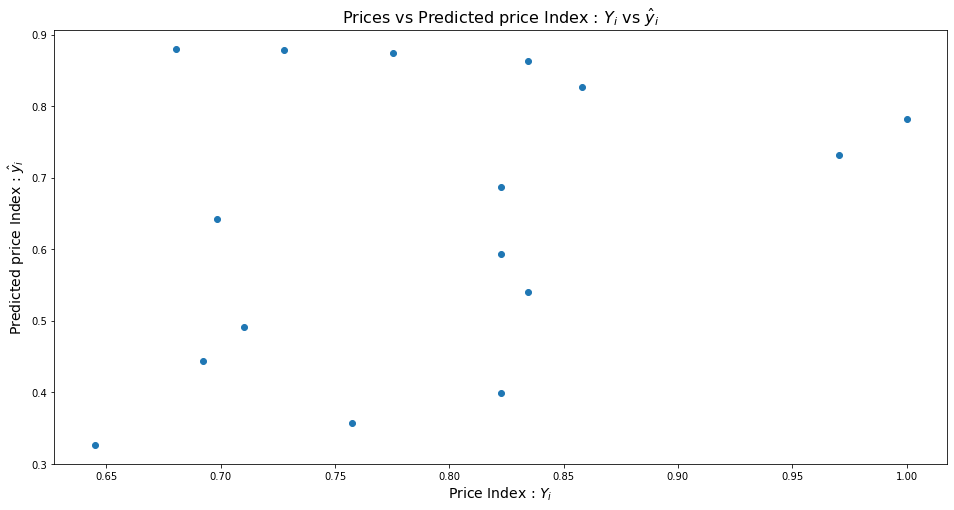

In [ ]:
plt.figure(figsize=(16,8))
plt.scatter(y_test, y_pred)
plt.xlabel('Price Index : $Y_i$', fontsize=14)
plt.ylabel('Predicted price Index : $\hat{y}_i$', fontsize=14)
plt.title('Prices vs Predicted price Index : $Y_i$ vs $\hat{y}_i$', fontsize=16)
plt.show()